<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Sentiment analysis con Bag of Words

### Objetivo
El objetivo es utilizar las críticas de películas para que el sistema determine si la evaluación es positiva o negativa (sentiment analysis como clasificador binario de texto)

In [1]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def curva_roc(model, X_test, y_test):
    y_hat_prob = model.predict(X_test).ravel()
    #y_hat = [1 if x >= 0.5 else 0 for x in y_hat_prob]
    mask_positive = y_hat_prob >= 0.5
    mask_negative = y_hat_prob < 0.5
    y_hat = y_hat_prob
    y_hat[mask_positive] = 1
    y_hat[mask_negative] = 0
    y_hat = y_hat.astype(int)

    # Calcular la exactitud (accuracy)
    scores = model.evaluate(X_test, y_test)
    print("Accuracy:", scores[1])

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob)
    auc_keras = auc(fpr, tpr)
    print('auc_keras', auc_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Curva ROC test')
    plt.legend(loc='best')
    plt.show()

### Datos
Utilizaremos como dataset críticas de películas de IMDB puntuadas deforma positiva o negativa.\
Referencia del dataset: [LINK](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('imdb_dataset.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1fXW-u9NVbH1yhwU1AHzPVtgGyV1c8N3g'
    output = 'imdb_dataset.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1fXW-u9NVbH1yhwU1AHzPVtgGyV1c8N3g
To: /content/imdb_dataset.csv
66.2MB [00:02, 31.2MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('imdb_dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 1 - Limpieza de datos
- En los datos se observo que en la columna "review" hay código HTML de salto de línea.
- Tranformar la columna snetiment a 0 y 1



In [5]:
# En los datos se observó código de HTML de salto de línea <br />
import re
df_reviews = df.copy() 
df_reviews['review'] = df['review'].apply(lambda x: re.sub("<br />", "", x))
df_reviews['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
df_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [6]:
# Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

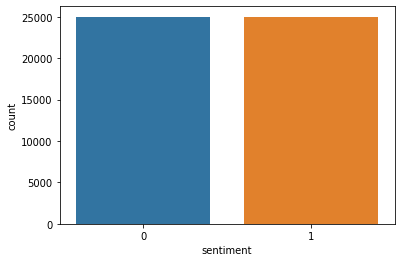

In [7]:
# Observar como está distribuido el dataset
sns.countplot(x='sentiment', data=df_reviews)
plt.show()

Se puede observar que el dataset está perfectamente balanceado

In [8]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['review'].values
text_sequences.shape

(50000,)

In [9]:
# Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

50000

In [10]:
# - Por defecto CountVectorizer elimina los signos de puntuacion y transforma
# todas las palabras a lowercase
# - max_features --> limitacion la máxima dimensión del oneHotEncoding (max vocab_size)
# - stop_words --> quitamos aquellas palabras que para el idioma no se consideran
# relevantes (como los árticulos, pronombres, preposiciones, adverbios, etc)
# - Referencia:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(text_sequences).toarray()

In [11]:
# Los datos de entrada (X) son un vector de oneHotEncoding del tamaño
# del vocabulario y de la cantidad de filas
X.shape

(50000, 2000)

In [12]:
# Tomar la columna rating y alcemacenarla en una variable "y"
# Su shape debe ser equivalente la cantidad de rows del corpus
y = df_reviews['sentiment'].values
print(y.shape)

(50000,)


In [13]:
# Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 1 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 2000 , out_shape 1


### 2 - Entrenar el modelo DNN con BOW

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Armar un modelo de clasificacion binaria con DNN
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(in_shape,)))
model.add(Dropout(rate=0.3))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               256128    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

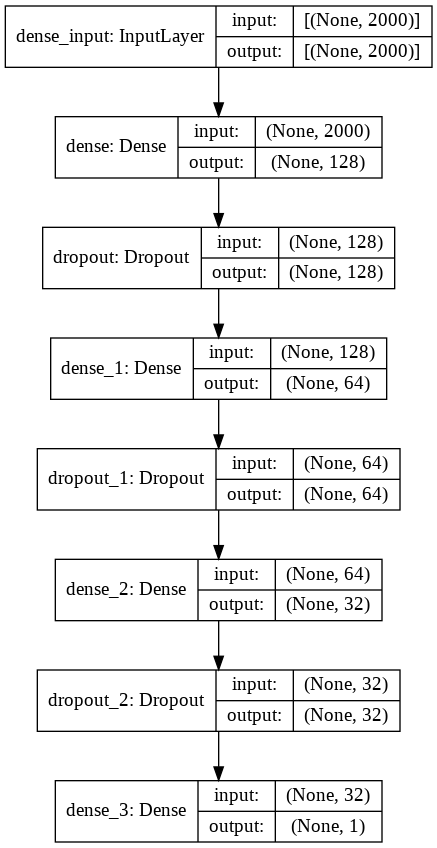

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
hist = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
1000/1000 [==============================] - 6s 5ms/step - loss: 0.4156 - accuracy: 0.8151 - val_loss: 0.3094 - val_accuracy: 0.8694
Epoch 2/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2958 - accuracy: 0.8837 - val_loss: 0.3126 - val_accuracy: 0.8679
Epoch 3/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2408 - accuracy: 0.9108 - val_loss: 0.3204 - val_accuracy: 0.8668
Epoch 4/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1737 - accuracy: 0.9386 - val_loss: 0.3774 - val_accuracy: 0.8650
Epoch 5/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.1232 - accuracy: 0.9582 - val_loss: 0.4439 - val_accuracy: 0.8565
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0856 - accuracy: 0.9719 - val_loss: 0.5042 - val_accuracy: 0.8568
Epoch 7/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0677 - accuracy: 0.9788 - val_loss: 0.5519 - val_accuracy:

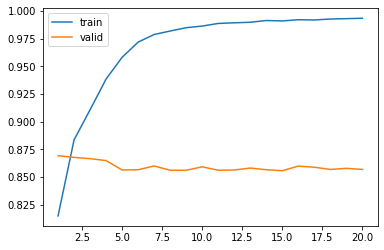

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [19]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.9971 - accuracy: 0.8593


[0.9970660209655762, 0.8593000173568726]

313/313 [==============================] - 1s 2ms/step - loss: 0.9971 - accuracy: 0.8593
Accuracy: 0.8593000173568726
auc_keras 0.8592329357318098


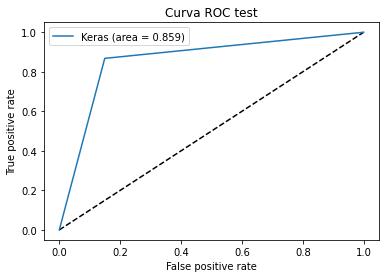

In [20]:
# Como este modelo es binario podemos calcular la curva ROC
curva_roc(model, X_test, y_test)

### 3 - Entrenar un modelo previamente reduciendo el vector de entrada (X)

In [21]:
# Un vector de 2000 columnas es demasiado grande para entrenar un modelo clásico
# de deep learning (DNN)
# Se utiliza PCA para reducir la dimensionalidad
from sklearn.decomposition import PCA
X_pca = PCA(n_components=50).fit_transform(X)

In [22]:
X_pca.shape

(50000, 50)

In [23]:
# Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [24]:
# Determinar la dimensiones de entrada y salida
in_shape = X_train2.shape[1] # max input sentence len
out_shape = 1 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 50 , out_shape 1


In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Utilizar la misma estructura de modelo del punto anterior
model2 = Sequential()
model2.add(Dense(units=128, activation='relu', input_shape=(in_shape,)))
model2.add(Dropout(rate=0.3))
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(rate=0.5))
model2.add(Dense(units=32, activation='relu'))
model2.add(Dropout(rate=0.5))
model2.add(Dense(units=out_shape, activation='sigmoid'))

model2.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               6528      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

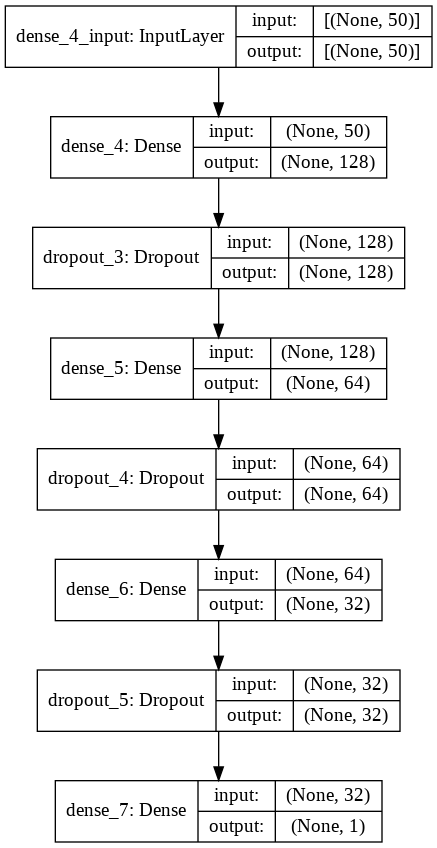

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
hist2 = model2.fit(X_train2, y_train2, epochs=20, validation_split=0.2)

Epoch 1/20
1000/1000 [==============================] - 3s 2ms/step - loss: 0.5726 - accuracy: 0.7056 - val_loss: 0.4866 - val_accuracy: 0.7700
Epoch 2/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5133 - accuracy: 0.7594 - val_loss: 0.4822 - val_accuracy: 0.7790
Epoch 3/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5013 - accuracy: 0.7662 - val_loss: 0.4787 - val_accuracy: 0.7747
Epoch 4/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4924 - accuracy: 0.7712 - val_loss: 0.4702 - val_accuracy: 0.7785
Epoch 5/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4860 - accuracy: 0.7755 - val_loss: 0.4668 - val_accuracy: 0.7810
Epoch 6/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4798 - accuracy: 0.7779 - val_loss: 0.4636 - val_accuracy: 0.7841
Epoch 7/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4742 - accuracy: 0.7790 - val_loss: 0.4624 - val_accuracy:

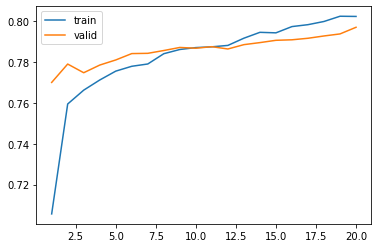

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [29]:
model2.evaluate(X_test2, y_test2)

313/313 [==============================] - 1s 2ms/step - loss: 0.4429 - accuracy: 0.7911


[0.4428715705871582, 0.791100025177002]

313/313 [==============================] - 1s 2ms/step - loss: 0.4429 - accuracy: 0.7911
Accuracy: 0.791100025177002
auc_keras 0.7910412669506813


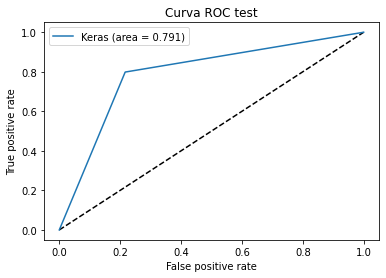

In [30]:
# Como este modelo es binario podemos calcular la curva ROC
curva_roc(model2, X_test2, y_test2)

### 4 - Conclusión
El modelo con "bag of words" resultó ser muy fácil de armar, barato de entrenar (liviano) y obtuvo una muy buena performance.\
El modelo de entrada completa (oneHotEncoding) performó mejor que el dimensión reducida con PCA pero realizó mucho overfitting.